Primera idea: Usar un CNN clasificadora en pedazos de la imagen, usando un modelo ya entrenado para clasificar objetos como es VGG16, entre estos objetos personas, y sumar cada vez que encuentra una... Problema al realizar esta idea, no se como manipular las capas de keras para hacer este tipo de busqueda
Segunda idea: Después de pensar algo que pueda ser feasible, decidi usar solo un regresor CNN, para intentar determinar la cantidad de personas.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from collections import defaultdict
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import cv2
import numpy as np
import time
from livelossplot import PlotLossesKeras

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dato = np.load(os.path.join(os.getcwd(),'data','images_train.npy'))

In [3]:
print(dato.shape)

(1600, 480, 640, 3)


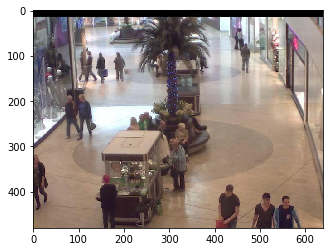

In [4]:
plt.imshow(dato[1559])
plt.show()

Primer intento CNN con la data normal

In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd

X_label = pd.read_csv(os.path.join(os.getcwd(),'data','labels_train.csv'))
y_total = np.asarray(X_label['count'])
X_train, X_val, y_train, y_val = train_test_split(dato,y_total, test_size=0.3, random_state=0, shuffle=False)

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_label.shape)
print(X_label)

(1120, 480, 640, 3)
(480, 480, 640, 3)
(1600, 2)
        id  count
0      401     29
1      402     30
2      403     31
3      404     26
4      405     26
5      406     28
6      407     27
7      408     29
8      409     31
9      410     37
10     411     37
11     412     41
12     413     40
13     414     42
14     415     36
15     416     37
16     417     38
17     418     37
18     419     40
19     420     37
20     421     41
21     422     41
22     423     36
23     424     33
24     425     37
25     426     36
26     427     35
27     428     36
28     429     33
29     430     31
...    ...    ...
1570  1971     25
1571  1972     30
1572  1973     29
1573  1974     28
1574  1975     28
1575  1976     27
1576  1977     27
1577  1978     30
1578  1979     30
1579  1980     30
1580  1981     30
1581  1982     29
1582  1983     34
1583  1984     33
1584  1985     35
1585  1986     36
1586  1987     31
1587  1988     26
1588  1989     26
1589  1990     26
1590  1991     

Modelo

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
modelCNN = Sequential()
modelCNN.add(Conv2D(32, (7, 7), padding='same', input_shape=X_train.shape[1:]))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(32, (7, 7), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(64, (7, 7), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(1000))
modelCNN.add(Dense(400))
modelCNN.add(Dense(1))
modelCNN.compile(loss='mean_squared_error', optimizer='adam')
modelCNN.summary()

La cantidad de parametros es inmensa por lo que se decide antes de probarla, reducir el tamaño de las imagenes

In [ ]:

history1 = modelCNN.fit(X_train, y_train,
          epochs=1,batch_size=1,
          validation_data=(X_val, y_val),
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [8]:
X_train_r = X_train
X_val_r = X_val

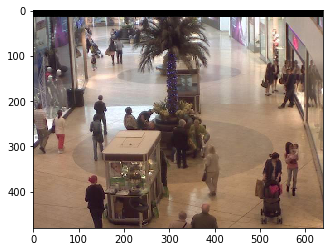

In [9]:
ej = X_train[0]
plt.imshow(ej)
plt.show()

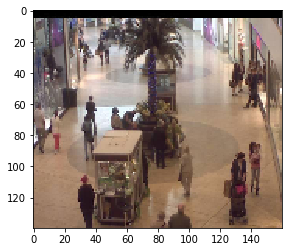

In [10]:
res = cv2.resize(X_train[0], dsize=(160, 140), interpolation=cv2.INTER_CUBIC)
plt.imshow(res)
plt.show()

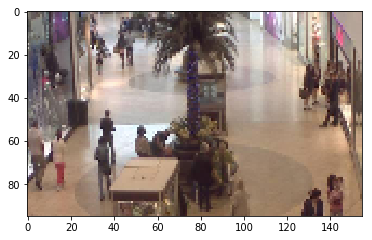

In [11]:
crop_img = res[9:104, 0:155]
plt.imshow(crop_img)
plt.show()

In [12]:
from tqdm import tqdm_notebook as tqdm
X_train_r = []
X_val_r = []
for i in tqdm(range(X_train.shape[0])):
    res = cv2.resize(X_train[i], dsize=(160, 140), interpolation=cv2.INTER_CUBIC)
    crop_img = res[9:104, 0:155]
    X_train_r.append(crop_img)
X_train_r = np.asarray(X_train_r)
for i in tqdm(range(X_val.shape[0])):    
    res = cv2.resize(X_val[i], dsize=(160, 140), interpolation=cv2.INTER_CUBIC)
    crop_img = res[9:104, 0:155]
    X_val_r.append(crop_img)
X_val_r = np.asarray(X_val_r)

HBox(children=(IntProgress(value=0, max=1120), HTML(value='')))

HBox(children=(IntProgress(value=0, max=480), HTML(value='')))

In [13]:
print(X_train_r.shape)
print(X_val_r.shape)

(1120, 95, 155, 3)
(480, 95, 155, 3)


In [210]:
modelCNN = Sequential()
modelCNN.add(Conv2D(32, (7, 7), padding='same', input_shape=X_train_r.shape[1:]))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(16, (3, 3), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(32, (7, 7), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(32, (3, 3), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Conv2D(64, (7, 7), padding='same'))
modelCNN.add(Activation('relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Flatten())
modelCNN.add(Dense(1000))
modelCNN.add(Dense(400))
modelCNN.add(Dense(1))
modelCNN.compile(loss='mean_squared_error', optimizer='adam')
modelCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 95, 155, 32)       4736      
_________________________________________________________________
activation_20 (Activation)   (None, 95, 155, 32)       0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 47, 77, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 47, 77, 16)        4624      
_________________________________________________________________
activation_21 (Activation)   (None, 47, 77, 16)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 23, 38, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 23, 38, 32)        25120     
__________

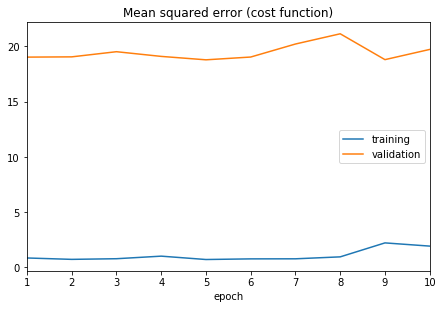

In [249]:
plt.close('all')
history2 = modelCNN.fit(X_train_r, y_train,
          epochs=10,batch_size=64,
          validation_data=(X_val_r, y_val),
          callbacks=[PlotLossesKeras()],
          verbose=0)

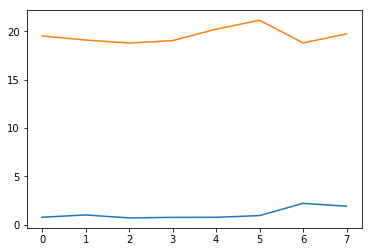

In [250]:
plt.plot(history2.history['loss'][2:])
plt.plot(history2.history['val_loss'][2:])
plt.show()

In [251]:
modelCNN.save('CNN8.h5')

In [252]:
X_test = np.load(os.path.join(os.getcwd(),'data','images_test.npy'))
X_test_r = []
for i in tqdm(range(X_test.shape[0])):    
    res = cv2.resize(X_test[i], dsize=(160, 140), interpolation=cv2.INTER_CUBIC)
    crop_img = res[9:104, 0:155]
    X_test_r.append(crop_img)
X_test_r = np.asarray(X_test_r)
y_predict = modelCNN.predict(X_test_r,batch_size=1)

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

In [253]:
print(y_predict)

[[30.13951 ]
 [35.456654]
 [37.881382]
 [33.75125 ]
 [41.61343 ]
 [38.142044]
 [34.39702 ]
 [40.613632]
 [28.01326 ]
 [26.682745]
 [16.446898]
 [21.463013]
 [24.44268 ]
 [29.346033]
 [16.336037]
 [14.599108]
 [14.156863]
 [23.982382]
 [30.384491]
 [27.210968]
 [26.01483 ]
 [24.687714]
 [23.67177 ]
 [24.24089 ]
 [25.63124 ]
 [25.541296]
 [20.747952]
 [27.860798]
 [28.131329]
 [25.549631]
 [23.116314]
 [29.96243 ]
 [24.037064]
 [20.892815]
 [18.61429 ]
 [19.090034]
 [28.182446]
 [26.5849  ]
 [27.245968]
 [31.082844]
 [30.202202]
 [26.211906]
 [20.838478]
 [21.377157]
 [28.298742]
 [24.16586 ]
 [23.214897]
 [22.465918]
 [28.75014 ]
 [28.107552]
 [18.334255]
 [14.911711]
 [17.665648]
 [24.31275 ]
 [16.636637]
 [22.285286]
 [23.203932]
 [27.53047 ]
 [25.269407]
 [17.559118]
 [14.664698]
 [14.305802]
 [26.298695]
 [22.486103]
 [26.986526]
 [26.92578 ]
 [34.00253 ]
 [32.101353]
 [33.100964]
 [31.710007]
 [26.401258]
 [33.010925]
 [38.029037]
 [37.828594]
 [44.728058]
 [41.979156]
 [41.31669 ]

In [254]:
d = {k+1:int(round(v[0])) for k,v in enumerate(y_predict)}
import pandas as pd
df = pd.Series(d).to_frame()
print(df.head(10))
df.to_csv('csvCNN8.csv')

     0
1   30
2   35
3   38
4   34
5   42
6   38
7   34
8   41
9   28
10  27


Intento con red RetinaNet

In [56]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join(os.getcwd(), 'snapshots', 'resnet50_coco_best_v2.1.0.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [57]:
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

In [186]:
# load image
resultados = defaultdict(int)
images = os.listdir(os.path.join(os.getcwd(),'data','frames_test'))
idxim = 1
for name in images:
    print(name)
    image = read_image_bgr(os.path.join(os.getcwd(),'data','frames_test',name))

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    
    # correct for image scale
    boxes /= scale
    
    # visualize detections
    count = 0
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.45:
            break
            
        color = label_color(label)
        
        b = box.astype(int)
        draw_box(draw, b, color=color)
        caption = "{} {:.3f}".format(labels_to_names[label], score)
        if label==0:
            count= count + 1
        draw_caption(draw, b, caption)
    print('personas: {}'.format(count))
    resultados[idxim]= count
    idxim= idxim+1
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.savefig(os.path.join(os.getcwd() ,'save',name))

seq_000001.jpg
processing time:  0.22569966316223145
personas: 21


c:\users\caimapo\appdata\local\programs\python\python36\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


seq_000002.jpg
processing time:  0.2184152603149414
personas: 24
seq_000003.jpg
processing time:  0.22340178489685059
personas: 25
seq_000004.jpg
processing time:  0.22348380088806152
personas: 23
seq_000005.jpg
processing time:  0.2258603572845459
personas: 22
seq_000006.jpg
processing time:  0.22042059898376465
personas: 21
seq_000007.jpg
processing time:  0.2263941764831543
personas: 18
seq_000008.jpg
processing time:  0.22240495681762695
personas: 23
seq_000009.jpg
processing time:  0.2154238224029541
personas: 11
seq_000010.jpg
processing time:  0.223402738571167
personas: 12
seq_000011.jpg
processing time:  0.19946670532226562
personas: 9
seq_000012.jpg
processing time:  0.18849492073059082
personas: 8
seq_000013.jpg
processing time:  0.21442508697509766
personas: 15
seq_000014.jpg
processing time:  0.21642017364501953
personas: 18
seq_000015.jpg
processing time:  0.19148659706115723
personas: 7
seq_000016.jpg
processing time:  0.20245838165283203
personas: 9
seq_000017.jpg
proce

personas: 14
seq_000127.jpg
processing time:  0.23138093948364258
personas: 15
seq_000128.jpg
processing time:  0.22240471839904785
personas: 20
seq_000129.jpg
processing time:  0.22340059280395508
personas: 19
seq_000130.jpg
processing time:  0.22196197509765625
personas: 19
seq_000131.jpg
processing time:  0.22495770454406738
personas: 23
seq_000132.jpg
processing time:  0.2354445457458496
personas: 21
seq_000133.jpg
processing time:  0.22539710998535156
personas: 26
seq_000134.jpg
processing time:  0.22542023658752441
personas: 26
seq_000135.jpg
processing time:  0.2403573989868164
personas: 16
seq_000136.jpg
processing time:  0.22244644165039062
personas: 20
seq_000137.jpg
processing time:  0.2234025001525879
personas: 20
seq_000138.jpg
processing time:  0.22838854789733887
personas: 21
seq_000139.jpg
processing time:  0.22838830947875977
personas: 17
seq_000140.jpg
processing time:  0.2263941764831543
personas: 20
seq_000141.jpg
processing time:  0.23038339614868164
personas: 27
s

processing time:  0.2313823699951172
personas: 22
seq_000252.jpg
processing time:  0.22054457664489746
personas: 24
seq_000253.jpg
processing time:  0.21792268753051758
personas: 20
seq_000254.jpg
processing time:  0.22140789031982422
personas: 23
seq_000255.jpg
processing time:  0.2263939380645752
personas: 23
seq_000256.jpg
processing time:  0.22240495681762695
personas: 18
seq_000257.jpg
processing time:  0.21941256523132324
personas: 19
seq_000258.jpg
processing time:  0.2234025001525879
personas: 23
seq_000259.jpg
processing time:  0.22420907020568848
personas: 17
seq_000260.jpg
processing time:  0.229323148727417
personas: 13
seq_000261.jpg
processing time:  0.2074451446533203
personas: 8
seq_000262.jpg
processing time:  0.21043658256530762
personas: 9
seq_000263.jpg
processing time:  0.2124311923980713
personas: 9
seq_000264.jpg
processing time:  0.22240471839904785
personas: 15
seq_000265.jpg
processing time:  0.21941256523132324
personas: 19
seq_000266.jpg
processing time:  0.

seq_000376.jpg
processing time:  0.21642065048217773
personas: 16
seq_000377.jpg
processing time:  0.21342873573303223
personas: 16
seq_000378.jpg
processing time:  0.22040939331054688
personas: 13
seq_000379.jpg
processing time:  0.21741819381713867
personas: 18
seq_000380.jpg
processing time:  0.2154233455657959
personas: 13
seq_000381.jpg
processing time:  0.22140789031982422
personas: 15
seq_000382.jpg
processing time:  0.23038291931152344
personas: 19
seq_000383.jpg
processing time:  0.21941256523132324
personas: 16
seq_000384.jpg
processing time:  0.2196500301361084
personas: 13
seq_000385.jpg
processing time:  0.2270822525024414
personas: 17
seq_000386.jpg
processing time:  0.21744704246520996
personas: 17
seq_000387.jpg
processing time:  0.2263944149017334
personas: 19
seq_000388.jpg
processing time:  0.22340154647827148
personas: 16
seq_000389.jpg
processing time:  0.2244246006011963
personas: 18
seq_000390.jpg
processing time:  0.22439861297607422
personas: 20
seq_000391.jpg


In [187]:
d2 = {k:v for k,v in resultados.items()}
import pandas as pd
df2 = pd.Series(d2).to_frame()
df2.head(10)
df2.to_csv('csvRNN2.csv')